In [ ]:
#Imports + Seed
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#Load preprocessed MEL images + labels
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

MEL_DIR = "/content/drive/MyDrive/irmas_multilabel_mels"
LABEL_CSV = "/content/drive/MyDrive/multilabel_labels.csv"

IMG_SIZE = 128

labels_df = pd.read_csv(LABEL_CSV)

X, y = [], []

for _, row in labels_df.iterrows():
    img_path = os.path.join(MEL_DIR, row["file"].replace(".wav", ".png"))
    if not os.path.exists(img_path):
        continue

    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0
    X.append(img)

    y.append(row[1:].values.astype("float32"))

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

print(X.shape, y.shape)

(1000, 128, 128, 3) (1000, 11)


In [ ]:
#SAME train/val split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

In [ ]:
#CNN model builder (optimizer as argument)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

def build_model(optimizer):
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation="relu"),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(y.shape[1], activation="sigmoid")
    ])

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["binary_accuracy"]
    )

    return model

In [ ]:
#Define optimizers (SAME LR)
LR = 0.0001

optimizers = {
    "SGD": SGD(learning_rate=LR),
    "Adam": Adam(learning_rate=LR),
    "RMSprop": RMSprop(learning_rate=LR)
}

In [ ]:
#Train all models (controlled experiment)
EPOCHS = 20
BATCH_SIZE = 32

histories = {}
models = {}

for name, opt in optimizers.items():
    print(f"\nTraining with {name}")

    model = build_model(opt)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    histories[name] = history
    models[name] = model


Training with SGD


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 901ms/step - binary_accuracy: 0.5956 - loss: 0.6853 - val_binary_accuracy: 0.6455 - val_loss: 0.6829
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 809ms/step - binary_accuracy: 0.6248 - loss: 0.6834 - val_binary_accuracy: 0.6709 - val_loss: 0.6813
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 850ms/step - binary_accuracy: 0.6143 - loss: 0.6821 - val_binary_accuracy: 0.6868 - val_loss: 0.6797
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 793ms/step - binary_accuracy: 0.6501 - loss: 0.6794 - val_binary_accuracy: 0.7123 - val_loss: 0.6782
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 866ms/step - binary_accuracy: 0.6531 - loss: 0.6788 - val_binary_accuracy: 0.7505 - val_loss: 0.6767
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 784ms/step - binary_accuracy: 0.6772 - loss: 0.6767 - val_binary_accuracy: 0.7736 - val_loss: 0.6751
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 860ms/step - binary_accuracy: 0.6793 - loss: 0.6755 - val_binary_accuracy: 0.7773 - val_loss: 0.6736

In [ ]:
#Evaluation (Recall + F1)
from sklearn.metrics import precision_score, recall_score, f1_score

THRESHOLD = 0.2
results = {}

for name, model in models.items():
    y_pred = model.predict(X_val)
    y_pred_bin = (y_pred >= THRESHOLD).astype(int)

    precision = precision_score(y_val, y_pred_bin, average="micro")
    recall = recall_score(y_val, y_pred_bin, average="micro")
    f1 = f1_score(y_val, y_pred_bin, average="micro")

    results[name] = {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f"\n{name}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step

SGD
Precision: 0.22363636363636363
Recall: 1.0
F1-score: 0.3655274888558692
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step

Adam
Precision: 0.2757452574525745
Recall: 0.8272357723577236
F1-score: 0.4136178861788618


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 524ms/step

RMSprop
Precision: 0.24237472766884532
Recall: 0.9044715447154471
F1-score: 0.38230240549828176


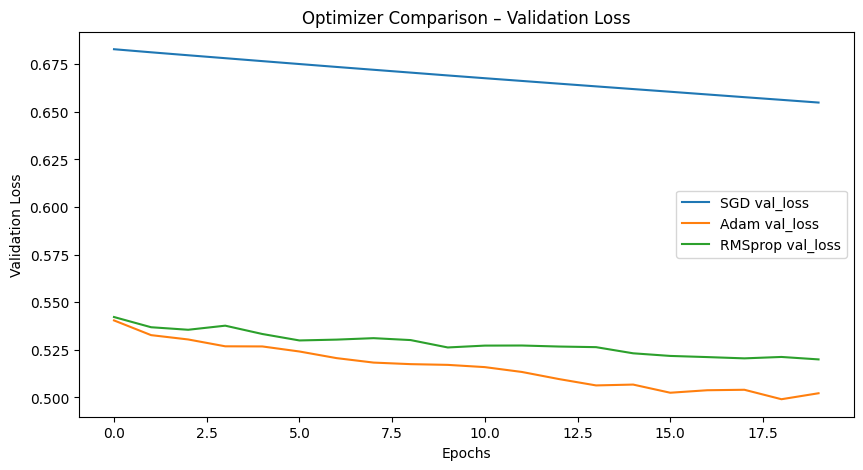

In [ ]:
#Convergence comparison (LOSS curves)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

for name, history in histories.items():
    plt.plot(history.history["val_loss"], label=f"{name} val_loss")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Optimizer Comparison – Validation Loss")
plt.legend()
plt.show()

# **Conclusion**
In this experiment, three optimizers—SGD, Adam, and RMSprop—were evaluated under identical training conditions to study their impact on multilabel instrument classification. SGD achieved perfect recall but very low precision, indicating excessive overprediction of instrument labels. RMSprop showed improved balance compared to SGD but still produced a lower F1-score. Adam achieved the best trade-off between precision and recall, resulting in the highest F1-score among the three optimizers. This indicates more stable convergence and better generalization performance. Based on these results, Adam was selected as the most suitable optimizer for the multilabel Instrunet AI model.